# Tool for Statistical Testing

This tool shows how we can apply a statistical test on two independent or two paired samples and is subdivided into the following parts:
- [Parameters](#Parameters): Parameter for the test that need to be specified (filenames, variable names, alternative).
- [Importing the Data](#Importing-the-Data): Here the needed data are imported.
- [Tests: Preliminary Code](#Tests:-Preliminary-Code): Code that need to be run before executing the statistical tests.
- [Tests for paired samples](#Tests-for-paired-samples): Use this section if your data are paired.
- [Tests for independent samples](#Tests-for-independent-samples): Use this section if your data are independent.


**General setting**

Given two methods (algorithms) **A** and **B** we have the **null hypothesis** $H_0$:

$H_0: \theta_A = \theta_B$

Here $\theta$ denotes the ground truth of a property (e.g. the expected run time or expected objective function value) of the algorithms **A** and **B**.

The **alternative hypothesis** $H_1$ depends on whether we want to apply a **two-sided** or **one-sided** test.

- **two-sided test**: Is there a statistically signifcant **difference** between **A** and **B** (e.g. **A** leads to smaller *or* greater objective function values)?
  - $H_1: \theta_A \neq \theta_B$ (```alternative = "two-sided"```)

- **one-sided test**: Does **A** or **A** lead to **better** results (e.g. smaller objective function values in minimization problems)?
  - $H_1: \theta_A > \theta_B$ (```alternative = "greater"```)
  - $H_1: \theta_A < \theta_B$ (```alternative = "less"```)


**Provided tests for two paired samples**

Two samples are **paired** (also called **related**), if the runtimes or objective function values of **A** and **B** are determined on the **same** instances.
In this case we have $n$ pairs of measurements for both algorithms.
This tool provides two statistical **tests for two paired samples**:
- **t-Test**: Applicable, if the difference of both samples is (approximately) normally distributed. Also applicable, if the sample size $n$ is large enough ($n \geq 30$) **and** the distribution is not too skewed **and** the sample (the difference) do not contain outliers.
- **Wilcoxon-Test**: Alternative, if the assumptions of the t-Test are not fulfilled.


**Provided tests for two independent samples**

Two samples are independent, if the runtimes or objective function values of **A** and **B** are determined on **different** instances. This tool provides two statistical **tests for two independent samples**:
- **t-Test**: Applicable, if the data of both samples are (approximately) normally distributed. Also applicable, if the sample size of both samples $n_A$ and $n_B$ are large enough ($n_A \geq 30$ and $n_B \geq 30$) **and** the distribution is not too skewed **and** the samples do not contain outliers. $n_A$ and $n_B$ should be (approximately) equal.
- **Wilcoxon-Test (U-Test)**: Alternative, if the assumptions of the t-Test are not fulfilled.

## Parameters

Parameters for **data import**:
- ```file_A```: Path to the file, where the results of algorithm **A** can be found.
- ```file_B```: Path to the file, where the results of algorithm **B** can be found. The results of **A** and **B** can also be contained in the same file.
- ```name_a```: Name of the column, where the results of algorithm **A** can be found.
- ```name_b```: Name of the column, where the results of algorithm **B** can be found.

Parameters for the **tests**:
- ```alternative```: Which alternative $H_1$ should be tested? ```"two-sided"```, ```"greater"``` or ```"less"``` (see above)
- ```alpha```: level of significance (usually $0.05$)

In [17]:
# Parameters for data import to be set
file_A_50 = "Data_50.csv"
file_B_50 = "Data_50.csv"
file_A_100 = "Data_100.csv"
file_B_100 = "Data_100.csv"
file_A_200 = "Data_200.csv"
file_B_200 = "Data_200.csv"

name_A = "obj_genetic"
name_B = "obj_grasp"
name_A_200 = "obj_aco"
name_B_200 = "obj_grasp"

# Parameters for the tests to be set
alternative = "two-sided"
alpha = 0.05

## Importing the Data

It is assumed that the data are given in **csv-format**.
Columns are separeted by a **semicolon** ```;``` and the first row contains the **names of the variables**. Furthermore it is assumed that for decimal numbers the **decimal point** ```.``` is used.

The following example is based on ```Daten.csv``` (see TUWEL), where the results of **A** and **B** are given in the same file.
It is assumed, that this file lies in the subfolder ```data``` of this notebook.

In [18]:
# Importing the data
import pandas as pd

df_A_50 = pd.read_csv(file_A_50, sep = ";", decimal = ".", usecols = [name_A])
df_B_50 = pd.read_csv(file_B_50, sep = ";", decimal = ".", usecols = [name_B])
df_A_100 = pd.read_csv(file_A_100, sep = ";", decimal = ".", usecols = [name_A])
df_B_100 = pd.read_csv(file_B_100, sep = ";", decimal = ".", usecols = [name_B])
df_A_200 = pd.read_csv(file_A_200, sep = ";", decimal = ".", usecols = [name_A_200])
df_B_200 = pd.read_csv(file_B_200, sep = ";", decimal = ".", usecols = [name_B_200])

data_A_50 = df_A_50[name_A]
data_B_50 = df_B_50[name_B]
data_A_100 = df_A_100[name_A]
data_B_100 = df_B_100[name_B]
data_A_200 = df_A_200[name_A_200]
data_B_200 = df_B_200[name_B_200]

## Tests: Preliminary Code

The following packages need to be imported:

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# scipy contains statistical tests and other useful content
import scipy.stats
from scipy.stats import norm

We define some auxiliary functions:
- ```print_decision(pvalue, alpha```: Function that prints the results of a test. Input parameters:
  - ```pvalue```: the p-value of the test
  - ```alpha```: level of significance
- ```compute_pvalue```: Sometimes, statistical tests only provide two-sided p-values. In case of one-sided tests, the p-value needs to be corrected accordingly. This is what this function does. Input parameters:
  - ```pvalue```: the two-sided p-value
  - ```diff```: the difference of the sample means (*mean(data_A) - mean(data_B)*)
  - ```alternative```: either ```"two-sided"```, ```"greater"``` or ```"less"```

In [20]:
def print_decision(pvalue, alpha):
    print("Test Result:")
    print("p-value = %.20f" % (pvalue))
    if pvalue < alpha:
        print("H0 can be rejected on a level of significance of " + str(alpha) + ".")
    else:
        print("H0 cannot be rejected on a level of significance of " + str(alpha) + ".")
        
def compute_pvalue(pvalue, diff, alternative):
    if alternative == "greater":
        if diff > 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    elif alternative == "less":
        if diff < 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    return pvalue

## Tests for paired samples

### Visualisation of the distribution of the difference

We check, whether the difference ```data_A - data_B``` is (approximately) normally distributed.
This can be done by plotting a **histogram**.
Furthermore we plot the **density of an estimated normal distribution**.
If the curve approximately follows the histogram, then normal distribution can be assumed.

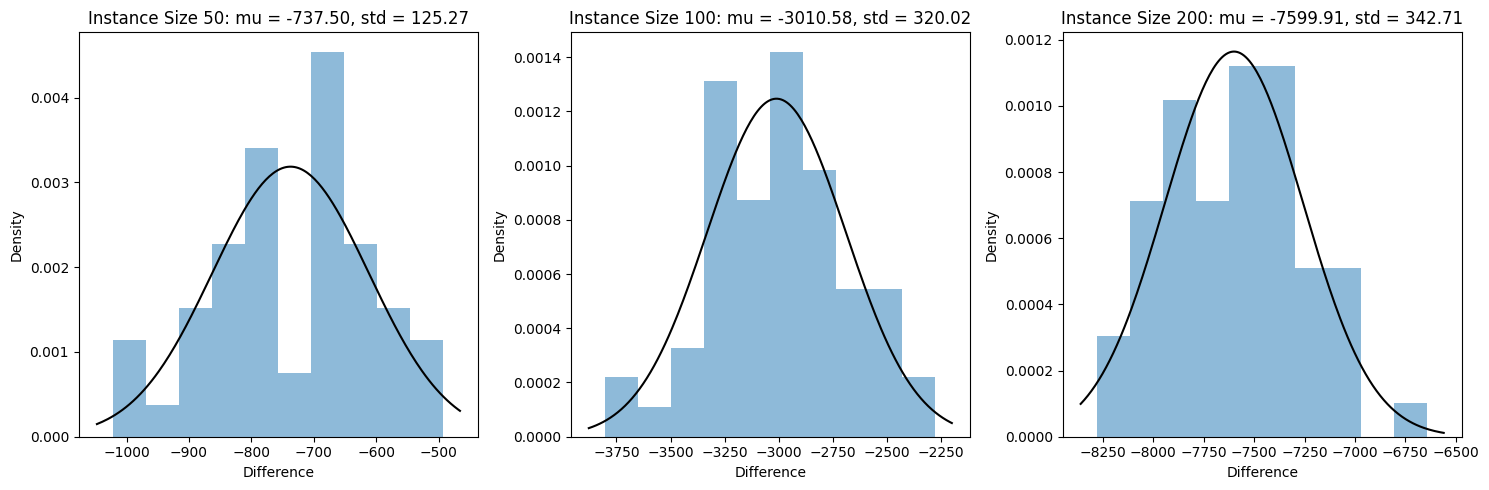

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Instance size 50
diff_50 = data_A_50 - data_B_50
axes[0].hist(diff_50, density=True, alpha=0.5)
mu_50, std_50 = norm.fit(diff_50)
xmin_50, xmax_50 = axes[0].get_xlim()
x_50 = np.linspace(xmin_50, xmax_50, 201)
y_50 = norm.pdf(x_50, mu_50, std_50)
axes[0].plot(x_50, y_50, "black")
axes[0].set_title("Instance Size 50: mu = %.2f, std = %.2f" % (mu_50, std_50))
axes[0].set_xlabel("Difference")
axes[0].set_ylabel("Density")

# Instance size 100
diff_100 = data_A_100 - data_B_100
axes[1].hist(diff_100, density=True, alpha=0.5)
mu_100, std_100 = norm.fit(diff_100)
xmin_100, xmax_100 = axes[1].get_xlim()
x_100 = np.linspace(xmin_100, xmax_100, 201)
y_100 = norm.pdf(x_100, mu_100, std_100)
axes[1].plot(x_100, y_100, "black")
axes[1].set_title("Instance Size 100: mu = %.2f, std = %.2f" % (mu_100, std_100))
axes[1].set_xlabel("Difference")
axes[1].set_ylabel("Density")

# Instance size 200
diff_200 = data_A_200 - data_B_200
axes[2].hist(diff_200, density=True, alpha=0.5)
mu_200, std_200 = norm.fit(diff_200)
xmin_200, xmax_200 = axes[2].get_xlim()
x_200 = np.linspace(xmin_200, xmax_200, 201)
y_200 = norm.pdf(x_200, mu_200, std_200)
axes[2].plot(x_200, y_200, "black")
axes[2].set_title("Instance Size 200: mu = %.2f, std = %.2f" % (mu_200, std_200))
axes[2].set_xlabel("Difference")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.show()

Besides the visual inspection, we can also perform a Shapiro-Wilk Test to assess the data's adherence to normality:

In [22]:
shapiro_wilk_test_50 = scipy.stats.shapiro(data_A_50 - data_B_50)
shapiro_wilk_test_100 = scipy.stats.shapiro(data_A_100 - data_B_100)
shapiro_wilk_test_200 = scipy.stats.shapiro(data_A_200 - data_B_200)

print("Shapiro-Wilk test for normality:")
print("--------------------------------")

for n, test in [("50", shapiro_wilk_test_50), ("100", shapiro_wilk_test_100), ("200", shapiro_wilk_test_200)]:
    print("Instance size %s: p-value = %.4f" % (n, test.pvalue))
    if test.pvalue < alpha:
        print("The null hypothesis of normality can be rejected.")
    else:
        print("The null hypothesis of normality cannot be rejected.")

Shapiro-Wilk test for normality:
--------------------------------
Instance size 50: p-value = 0.4721
The null hypothesis of normality cannot be rejected.
Instance size 100: p-value = 0.8063
The null hypothesis of normality cannot be rejected.
Instance size 200: p-value = 0.8285
The null hypothesis of normality cannot be rejected.


### t-Test for two paired samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

**Note**: Only the two-sided p-value is returned!

In [23]:
# Apply the statistical test
res_50 = scipy.stats.ttest_rel(data_A_50, data_B_50)
res_100 = scipy.stats.ttest_rel(data_A_100, data_B_100)
res_200 = scipy.stats.ttest_rel(data_A_200, data_B_200)
pvalue_50 = res_50.pvalue
pvalue_100 = res_100.pvalue
pvalue_200 = res_200.pvalue

# Compute the correct p-value (two-sided vs. one-sided)
pvalue_50 = compute_pvalue(res_50.pvalue, np.mean(data_A_50) - np.mean(data_B_50), alternative)
pvalue_100 = compute_pvalue(res_100.pvalue, np.mean(data_A_100) - np.mean(data_B_100), alternative)
pvalue_200 = compute_pvalue(res_200.pvalue, np.mean(data_A_200) - np.mean(data_B_200), alternative)

# Print results
print("Instance size 50, ", end="")
print_decision(pvalue_50, alpha)
print("--------------------------------")
print("Instance size 100, ", end="")
print_decision(pvalue_100, alpha)
print("--------------------------------")
print("Instance size 200, ", end="")
print_decision(pvalue_200, alpha)

Instance size 50, Test Result:
p-value = 0.00000000000000000000
H0 can be rejected on a level of significance of 0.05.
--------------------------------
Instance size 100, Test Result:
p-value = 0.00000000000000000000
H0 can be rejected on a level of significance of 0.05.
--------------------------------
Instance size 200, Test Result:
p-value = 0.00000000000000000000
H0 can be rejected on a level of significance of 0.05.


### Wilcoxon Test for two paired samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

In [24]:
# Apply the statistical test
res_50 = scipy.stats.wilcoxon(data_A_50, data_B_50, alternative = alternative)
res_100 = scipy.stats.wilcoxon(data_A_100, data_B_100, alternative = alternative)
res_200 = scipy.stats.wilcoxon(data_A_200, data_B_200, alternative = alternative)

# Print results
print("Instance size 50, ", end="")
print_decision(res_50.pvalue, alpha)
print("--------------------------------")
print("Instance size 100, ", end="")
print_decision(res_100.pvalue, alpha)
print("--------------------------------")
print("Instance size 200, ", end="")
print_decision(res_200.pvalue, alpha)

Instance size 50, Test Result:
p-value = 0.00000000000000177636
H0 can be rejected on a level of significance of 0.05.
--------------------------------
Instance size 100, Test Result:
p-value = 0.00000000001629555794
H0 can be rejected on a level of significance of 0.05.
--------------------------------
Instance size 200, Test Result:
p-value = 0.00000000001629555794
H0 can be rejected on a level of significance of 0.05.


### Plots depiciting variance of solutions

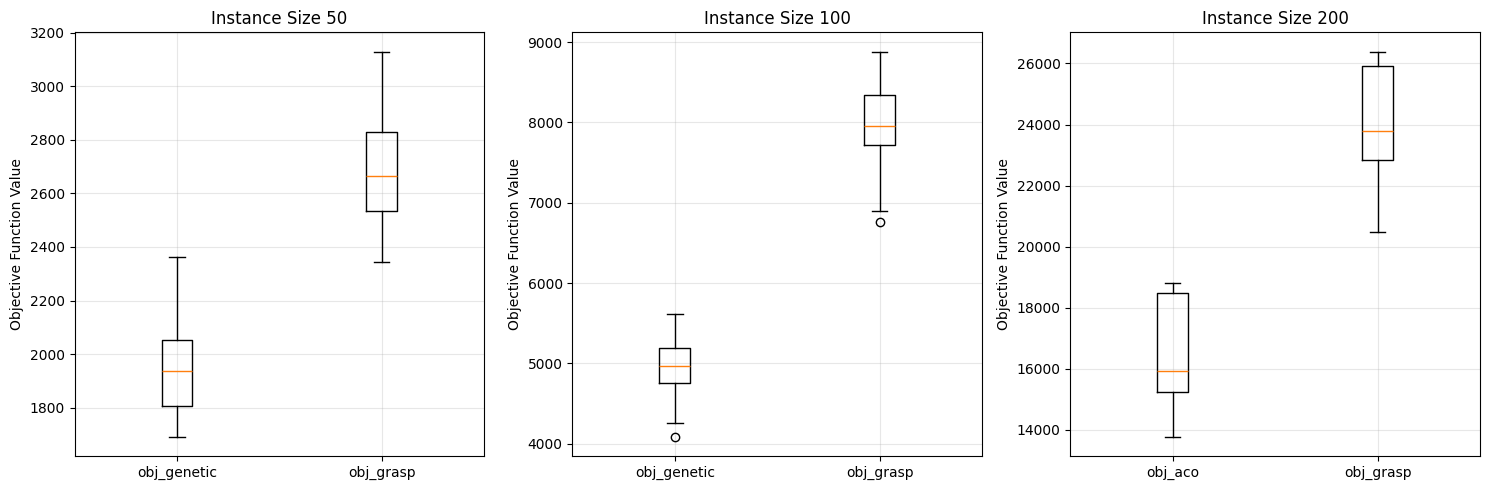

Instance Size 50:
Variance of obj_genetic: 34167.13
Variance of obj_grasp: 44549.41
Standard Deviation of obj_genetic: 184.84
Standard Deviation of obj_grasp: 211.07

Instance Size 100:
Variance of obj_genetic: 112525.70
Variance of obj_grasp: 275118.99
Standard Deviation of obj_genetic: 335.45
Standard Deviation of obj_grasp: 524.52

Instance Size 200:
Variance of obj_aco: 3062908.49
Variance of obj_grasp: 3280781.67
Standard Deviation of obj_aco: 1750.12
Standard Deviation of obj_grasp: 1811.29


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Instance size 50
axes[0].boxplot([data_A_50, data_B_50], tick_labels=[name_A, name_B])
axes[0].set_ylabel('Objective Function Value')
axes[0].set_title('Instance Size 50')
axes[0].grid(True, alpha=0.3)

# Instance size 100
axes[1].boxplot([data_A_100, data_B_100], tick_labels=[name_A, name_B])
axes[1].set_ylabel('Objective Function Value')
axes[1].set_title('Instance Size 100')
axes[1].grid(True, alpha=0.3)

# Instance size 200
axes[2].boxplot([data_A_200, data_B_200], tick_labels=[name_A_200, name_B_200])
axes[2].set_ylabel('Objective Function Value')
axes[2].set_title('Instance Size 200')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print variance statistics for all three instance sizes
print("Instance Size 50:")
print(f"Variance of {name_A}: {np.var(data_A_50):.2f}")
print(f"Variance of {name_B}: {np.var(data_B_50):.2f}")
print(f"Standard Deviation of {name_A}: {np.std(data_A_50):.2f}")
print(f"Standard Deviation of {name_B}: {np.std(data_B_50):.2f}")
print()

print("Instance Size 100:")
print(f"Variance of {name_A}: {np.var(data_A_100):.2f}")
print(f"Variance of {name_B}: {np.var(data_B_100):.2f}")
print(f"Standard Deviation of {name_A}: {np.std(data_A_100):.2f}")
print(f"Standard Deviation of {name_B}: {np.std(data_B_100):.2f}")
print()

print("Instance Size 200:")
print(f"Variance of {name_A_200}: {np.var(data_A_200):.2f}")
print(f"Variance of {name_B_200}: {np.var(data_B_200):.2f}")
print(f"Standard Deviation of {name_A_200}: {np.std(data_A_200):.2f}")
print(f"Standard Deviation of {name_B_200}: {np.std(data_B_200):.2f}")